# Pop-Up Course: Better metal forming by linking experiment, modeling, and process control  
#### July 29-30, 2019

## Monte Carlo Grain Growth Simulation

### What are grains and grain boundaries?

A crystalline material is one in which atoms are arranged on well-defined, periodic, crystallographic planes. A polycrystalline material can be defined as one in which crystalline regions or domains are separated by well-defined boundaries. Such domains are called grains, and the boundaries separating them are known as grain boundaries. While grains are crystalline and hence 'ordered' in nature, the grain boundaries are disordered, i.e., atoms in the grain boundaries are irregularly arranged. The disordered nature of a grain boundary results in an excess free energy compared to the bulk grain. 


### Why are grain boundaries important to a material?

Grain boundaries disrupt the continuity in the ordered arrangement of atoms. Since they resist the movement of dislocations, an additional stress is required to propogate dislocations through the material, i.e., cause plastic deformation. This increases the material's yield strength, as summarised in the Hall-Petch relationship: $\sigma \propto \frac{1}{\sqrt{d}}$. The difference in the arrangement of atoms in a grain boundary and a grain result in different atomic mobilities, thereby impacting diffusivity of atoms. Grain boundaries also act as sites of segregation for solute atoms and other impurities, thereby increasing the effective solubility limit of a solute in the material. 


### Why does grain growth occur?

Grain boundaries are regions of disordered material and thus have an excess free energy associated with them. A polycrystalline material thus contains excess energy proportional to the grain boundary area, and tends to reduce this energy through grain growth. The direction of grain growth is provided by the curvature of grain boundaries, with the growth always directed towards the center of curvature. Burke provided a mathematical construct for quantifying grain growth in isothermal conditions:

\begin{equation} \label{eqn:burke-turnbull}
D^{n}-{D_{0}}^{n} = kt
\end{equation}

where $D_{0}$ and $D$ are mean grain diameters at times 0 and t respectively, and n is the grain size exponent. When grain growth is driven only by curvature, n assumes a value of two(uninhibited growth). However, when factors such as solute segregation impacts the growth kinetics, n can assume a different value(inhibited growth). Examples of these two cases are shown in the next section. 

Applications based on nanocrystalline materials require a strict control of average grain size. Approaches such as grain boundary pinning by precipitates and inhibition of growth by solute segregation are quite common for applications that require a high degree of grain size stability. 










## Grain Growth, visualized in 2 dimensions

<img src = "gg.gif">

## Grain Growth, visualized in 3 dimensions

![GGUrl](https://upload.wikimedia.org/wikipedia/commons/3/38/Grgr3d_small.gif)

## Uninhibited and inhibited grain growth

The two major types of growth kinetics introduced in the first section are demonstrated below. There are two datafiles in the directory. They contain time vs grain diameter, but grain growth has been simulated with different conditions in the two cases. Consider the following as a simple exercise in python to load a datafile using pandas, plot time vs grain area, and fit the curve using a n-degree polynomial! 

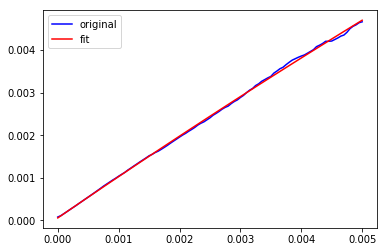

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df = pd.read_csv("Lin.txt", sep = '\t', header=None, names=['t', 'area', 'dia'])
time = df['t']
d = df['area']
c1, c2, c3 = np.polyfit(time, d, 2)

plt.plot(time, d, color = 'b', label = 'original')
plt.plot(time, c3 + c2*time + c1*time*time, color = 'r', label = 'fit')
plt.legend()
plt.show()

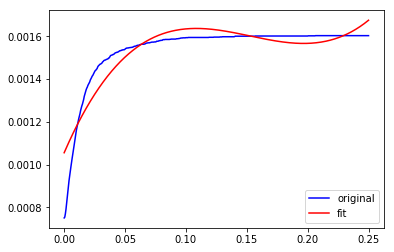

In [3]:
df1 = pd.read_csv("NonLin.txt", sep = '\t', header=None, names=['t', 'area', 'dia', 'a', 'b', 'c', 'd'])
time1 = df1['t']
d1 = df1['area']
c1, c2, c3, c4 = np.polyfit(time1, d1, 3)

plt.plot(time1, d1, color = 'b', label = 'original')
plt.plot(time1, c4 + c3*time1 + c2*time1*time1 + c1*time1**3, color = 'r', label = 'fit')
plt.legend()
plt.show()


### The Monte-Carlo Method
#### The Algorithm:
MC method based on Potts model has been used here, and is given by the following steps:
* A lattice site $i$, located at $x_i$, is selected out of total number of sites, $N_L$, based on a site selection probability.
* The orientation of site $i$, $S^0_i$, is switched randomly to one of its neighbor's, $S^n_i$, and a change in energy $\Delta E$ is computed by:
$$\Delta E=J\sum_{j=1}^{N_n} [\delta(S^0_i,S^j_i)-\delta(S^n_i,S^j_i)]$$
where, $N_n$ is total number of neighbouring lattice sites, $\delta$ is Kronecker delta function and $J$ is specific grain boundary energy.
* The final orientation is accepted with the probability:
$$\check{P}(\Delta E, T(x_i))= \begin{cases} 1  & if \Delta E \leq 0, \\ e^{-\Delta E/k_BT_s} & if \Delta E >0 \end{cases} $$
$N_L$ reorientation attempts over the entire domain is considered a global MC step.

In [4]:
# Import required libraries

import matplotlib.patches as patches
from IPython import display
import time

# Inline Plots
%matplotlib inline

Make a 2D square lattice:

In [5]:
nlp = 100  # number of lattice points
Nmcs=50 # number of monte carlo steps
N = (nlp + 1) * (nlp + 1)
Q = N  # Number of states in Q-state potts model
X = np.linspace(0, 1, nlp + 1)
x, y = np.meshgrid(X, X)

### Functions:

#### Neighborhood matrix and figure of a 3x3 lattice

This function creates a matrix that contains the state/orientation of all the neighboring lattice points of the selected lattice point.
<img src = "1.png" width="200">

In [6]:
def createNeighborStateMatrix(i, j,state):
    Jm1=j-1
    Jp1=j+1
    Im1=i-1
    Ip1=i+1
    
    # Periodic Boundary Condition
    if(i==0):
        Im1=len(state)-1
    if(i==len(state)-1):
        Ip1=0        
    if(j==0):
        Jm1=len(state)-1
    if(j==len(state)-1):
        Jp1=0
    # 3x3 matrix of state all cells surrounding current lattice point
    neighborStateMatrix = np.array([[state[Im1, Jm1], state[Im1, j], state[Im1, Jp1]],
                           [state[i, Jm1], state[i, j], state[i, Jp1]],
                           [state[Ip1, Jm1], state[Ip1, j], state[Ip1, Jp1]]])
    return neighborStateMatrix



This function calculates summation of the Kronecker Delta of a given state matrix for the following formula:

$$
\Delta E=J \sum_{j=1}^{N_{n}}\left[\delta\left(S_{i}^{0}, S_{i}^{j}\right)-\delta\left(S_{i}^{n}, S_{i}^{j}\right)\right]
$$

In [7]:
def calculateKroneckerDelta(neighborStateMatrix):
    kd = np.zeros([1, 8])
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 0]):
        kd[0, 0] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 1]):
        kd[0, 1] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[0, 2]):
        kd[0, 2] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[1, 2]):
        kd[0, 3] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 2]):
        kd[0, 4] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 1]):
        kd[0, 5] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[2, 0]):
        kd[0, 6] = 1
    if (neighborStateMatrix[1, 1] == neighborStateMatrix[1, 0]):
        kd[0, 7] = 1
    return sum(sum(kd))




This function flips the orientation of a lattice point randomly to one of its neighbor as demonstrated in the following figure


<img src = "latticeChange.gif" width="200">

In [8]:

def changeState(neighborStateMatrix):
    neighborI=1
    neighborJ=1
    
    while (neighborI==1) and (neighborJ==1):
        neighborI=np.random.randint(3)
        neighborJ=np.random.randint(3)
        neighborStateMatrix[1,1]=neighborStateMatrix[neighborI,neighborJ];
    return  neighborStateMatrix


**MC Loop:**

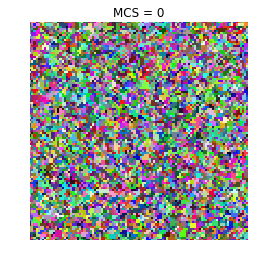

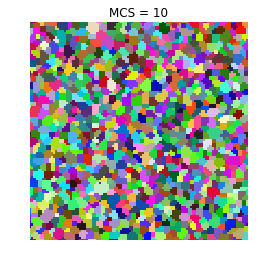

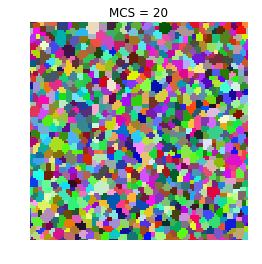

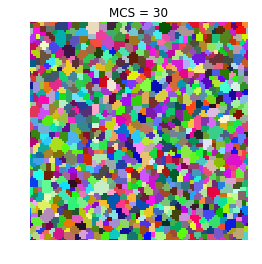

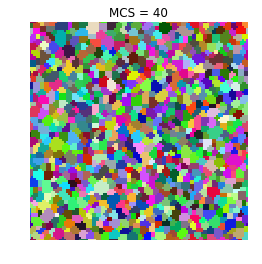

In [9]:
state = np.random.randint(Q, size=(x.shape))
colormatrix = np.random.rand(Q, 3)
neighborStateMatrix = np.zeros([3, 3])
for mcs in range(0,Nmcs):
    for n in range(0, N):
        # Pick random lattice cite
        i = np.random.randint(0, len(x))
        j = np.random.randint(0, len(x))
        neighborStateMatrix = createNeighborStateMatrix(i, j, state)
        energyBeforeChange = calculateKroneckerDelta(neighborStateMatrix)
        neighborStateMatrix=changeState(neighborStateMatrix)
        energyAfterChange = calculateKroneckerDelta(neighborStateMatrix)
        dE=energyBeforeChange-energyAfterChange
        if dE<0:
            state[i,j]=neighborStateMatrix[1,1]
    # Plotting as squares
    if (mcs%10.0==0):
        fig, ax = plt.subplots(1)
        for i in range(0, nlp + 1):
           for j in range(0, nlp + 1):
               rect = patches.Rectangle((x[i, j]-(0.5 / nlp), y[i, j]-(0.5 / nlp)), 1.0 / nlp, 1.0 / nlp,linewidth=1, edgecolor='none', facecolor=colormatrix[state[i, j], :])
               ax.add_patch(rect)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis('off')
        plt.title("MCS = %d"%mcs)
        display.display(plt.gcf())
        display.clear_output(wait=True)

MC simulation results can be related to physical processes by fitting experimental data. In MC simulations, the evolution of average grain size, $\bar{D}$, follows:
$$\bar{D}^m - \bar{D}^m_0 = \lambda^mCt_{mc}$$
Where, $m$ and $C$ are parameters fitted from simulations. Experimental studies have shown that grain growth physics for constant temperature is captured by the following model:
$$\bar{D}^n - \bar{D}^n_0 =Kt \ e^{-Q/RT }$$

<br />
<br />
<br />

Following the curve fitting exercise we did earlier, let us load some simulation data and fit it to experimental data found in literature:


Text(0, 0.5, 'grain size($\\mu$m)')

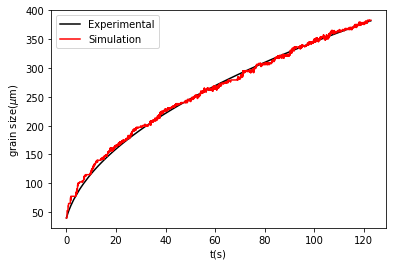

In [13]:
from scipy.optimize import least_squares

D0 = 40       #Initial grain size
Q  = 312000   # activation energy
K  = 1110e12  # growth constant
R  = 8.314    # gas constant
T  = 1361     # temperature in Kelvin
n  = 2        # grain growth exponent
lamda=5.0     # physical length of the lattice spacing
tmc=np.linspace(1,250000,250000)   # Monte-Carlo Steps

def fun(x):
     return (tmc-(DSim**x[0] - D0**x[0])/((lamda**x[0])*x[1]))**2

data = np.loadtxt("grainSizeSimulationAndExpt.txt", delimiter=" ")
DExpt=data[:,0]
DSim=data[:,1]

x0=[1,1]
result=least_squares(fun,x0)
x=result.x
m=x[0]
C=x[1]           

# Calculating physical time after fitting
t = (((lamda**m )*C*tmc + (D0**m))**(n/m)  -D0**n)/(K*np.exp(-Q/(R*T)));

plt.plot(t,DExpt,color = 'k', label = 'Experimental')
plt.plot(t,DSim,color = 'r', label = 'Simulation')
plt.legend()
plt.xlabel('t(s)')
plt.ylabel(r'grain size($\mu$m)')